In [67]:
from tqdm import tqdm
import pickle
import time
import functools
import warnings
warnings.filterwarnings("ignore")

from dabl import plot
import matplotlib.pyplot as plt
import matplotlib as mpl 
from mlxtend.plotting import plot_confusion_matrix, plot_decision_regions
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns 
from scipy.stats import friedmanchisquare, kruskal

from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN
from imblearn.pipeline import Pipeline
from imblearn.metrics import geometric_mean_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, fbeta_score, matthews_corrcoef, cohen_kappa_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, QuantileTransformer, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb


In [61]:
set_config(display="diagram")

In [2]:
mpl.rcParams["figure.figsize"] = (20, 6)
mpl.rcParams["axes.titlesize"] = 20
mpl.rcParams["axes.labelsize"] = 13

# [Stroke Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?select=healthcare-dataset-stroke-data.csv)

[Stroke Disease Detection and Prediction Using Robust Learning Approaches](https://www.hindawi.com/journals/jhe/2021/7633381/)

In [29]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

# EDA

In [30]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [31]:
df.drop("id", axis=1, inplace=True)

In [32]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [33]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [34]:
df.describe(include="O")

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


In [35]:
print(f"""
gender: {', '.join(df.gender.unique())}
ever_married: {', '.join(df.ever_married.unique())}
work_type: {', '.join(df.work_type.unique())}
Residence_type: {', '.join(df.Residence_type.unique())}
smoking_status: {', '.join(df.smoking_status.unique())}
""")


gender: Male, Female, Other
ever_married: Yes, No
work_type: Private, Self-employed, Govt_job, children, Never_worked
Residence_type: Urban, Rural
smoking_status: formerly smoked, never smoked, smokes, Unknown



In [36]:
print(f"Numero de observações {len(df)}\nNumero de atributos {df.shape[-1]}")

Numero de observações 5110
Numero de atributos 11


<AxesSubplot:title={'center':'Percentual de Valores Faltantes em cada Atributo'}>

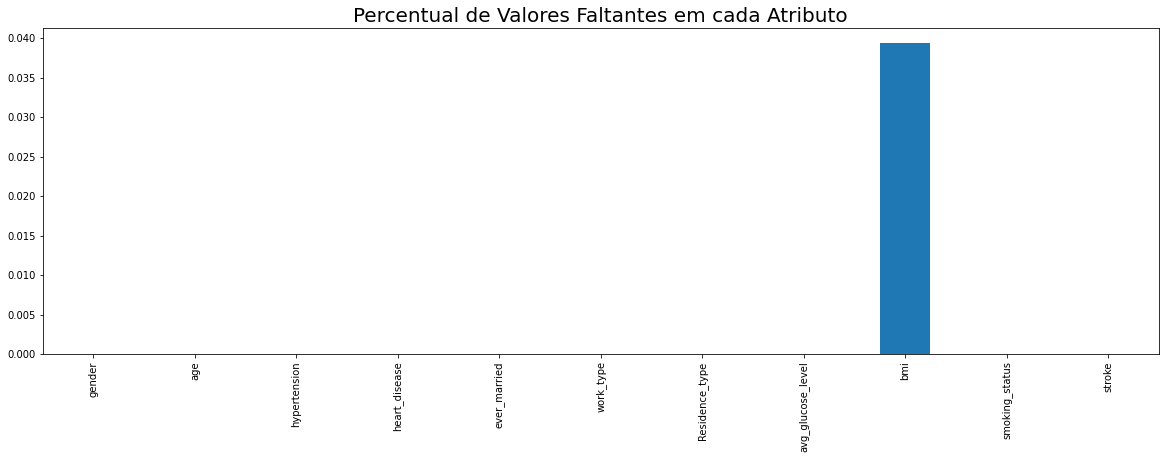

In [37]:
df.isna().mean().plot(kind="bar", title="Percentual de Valores Faltantes em cada Atributo")

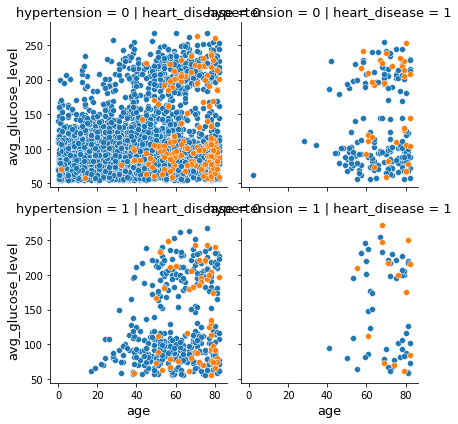

In [38]:
g = sns.FacetGrid(data=df, row="hypertension", col="heart_disease", hue="stroke")
g.map_dataframe(sns.scatterplot, x="age", y="avg_glucose_level")
plt.tight_layout()

In [39]:
fig = px.parallel_coordinates(df, color='stroke', color_continuous_scale=px.colors.diverging.Tealrose, color_continuous_midpoint=2)
fig.show()

In [40]:
fig = px.parallel_categories(df, color='stroke')
fig.show()

Target looks like classification
Linear Discriminant Analysis training set score: 0.500


[[<Figure size 648x648 with 12 Axes>,
  <Figure size 1152x288 with 4 Axes>,
  <Figure size 1440x432 with 1 Axes>],
 None]

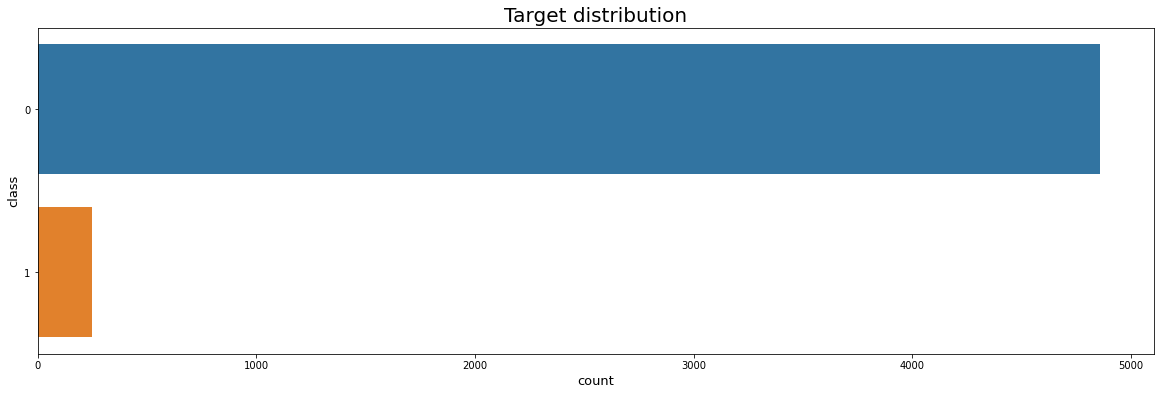

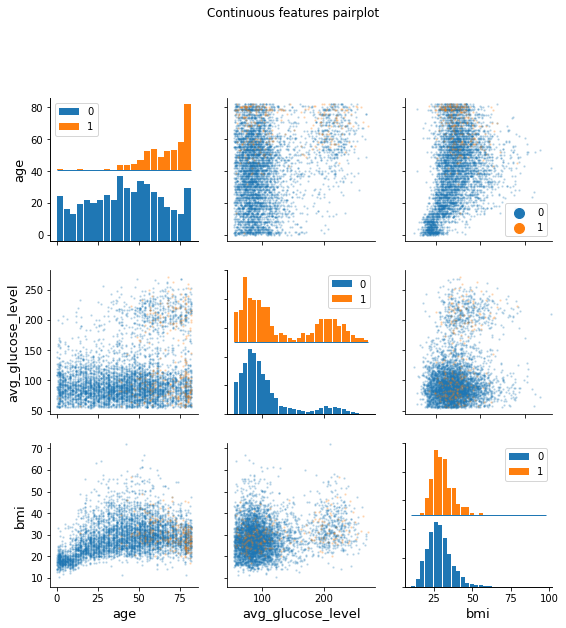

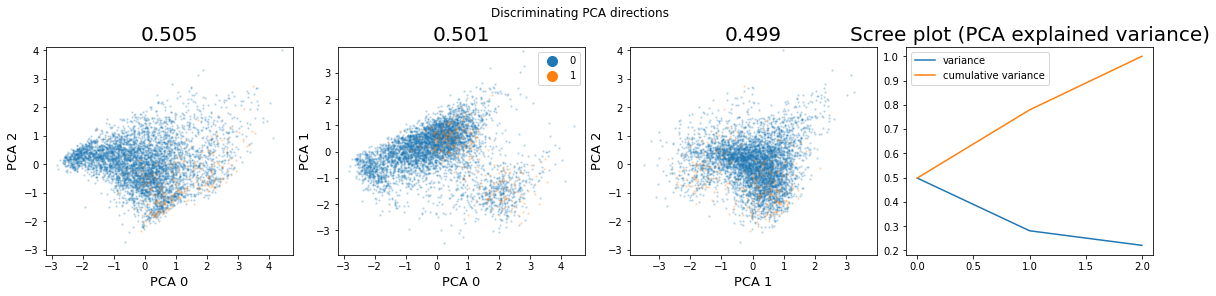

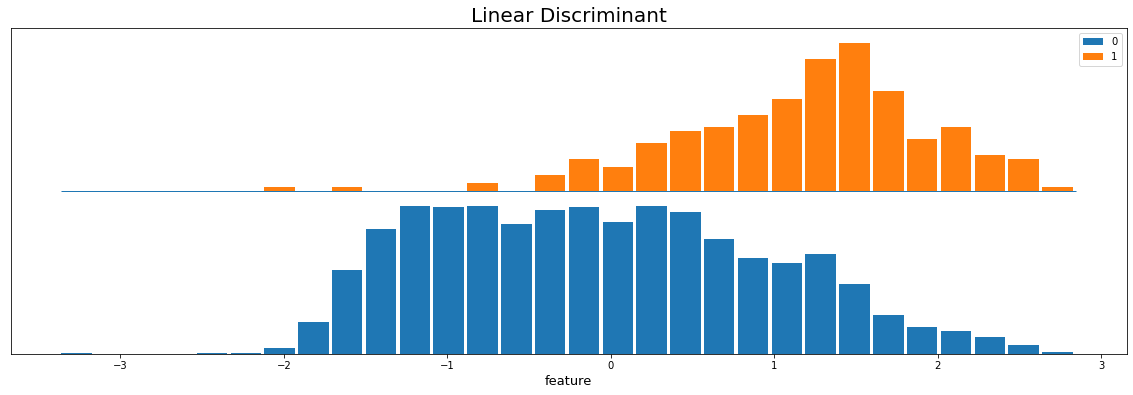

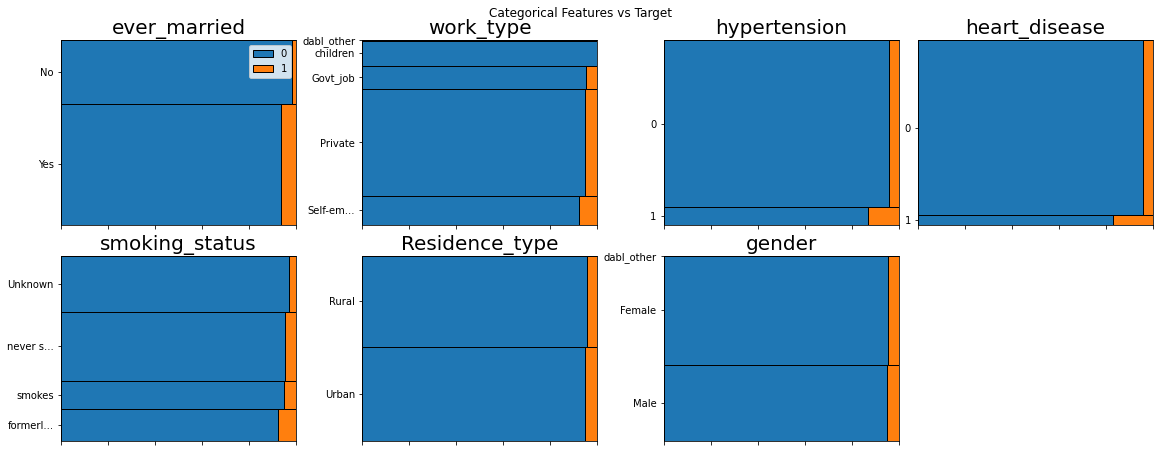

In [41]:
plot(df, y="stroke")

<AxesSubplot:>

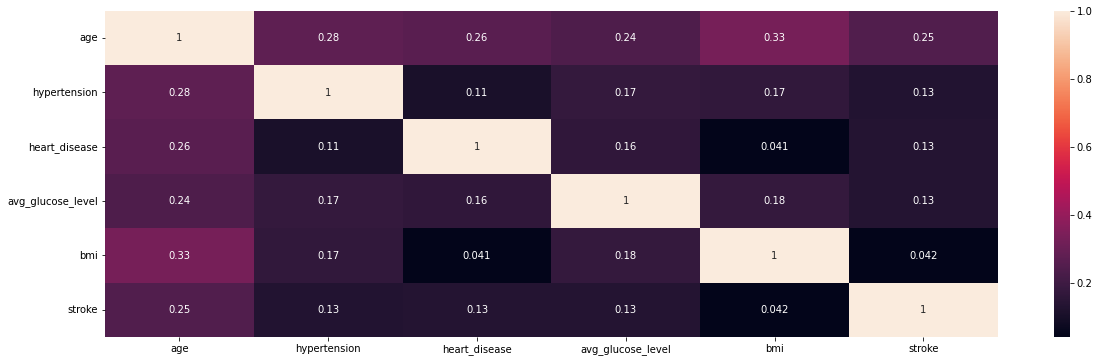

In [42]:
sns.heatmap(df.corr(), annot=True)

# Model Selection

In [43]:
X = df.loc[:, ~df.columns.str.contains("stroke")].copy()
y = df["stroke"].copy()

In [44]:
X.describe(include="O").columns.tolist()

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [45]:
cat_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease']
num_features = ["age", "avg_glucose_level", "bmi"]

## Creating Nested-Cross Validation Class

In [46]:
class Classifier:
    """Tune and selects classifier models based on a nested cross validation 
    from models that follow the same structure from sklearn. 

    Parameters
    ----------
    models : dict[str, tuple]
        A dictionary containg the classifier name and a tuple with the model
        object and the parameters' space that will be used in the tunnig part.
            Example:
                {
                    "Logistic": (
                        LogisticRegression(), 
                        {"Logistic__penalty": ["l1", "l2"]}
                    ),
                    "SVM": (
                        SVC(),
                        {"SVM__C": [1, 5, 10]}
                    )
                }
    preprocessing : ColumnTransformer
        The preprocssing step that will be used before fitting and 
        predictions.
    resampling_step : tuple, optional
        A tuple that contains the name for the resampling step and a resampler
        object from imblearn, by default ("resampling", SMOTE())
    inner_cv : int, optional
        _description_, by default 5
    outer_cv : int, optional
        _description_, by default 10
    scoring : dict[str, any], optional
        _description_, by default None
    optimize : str, optional
        _description_, by default None
    searcher : _type_, optional
        _description_, by default GridSearchCV
    kwargs_searcher : dict, optional
        _description_, by default None
    """
    def __init__(
        self, 
        models: dict[str, tuple],
        preprocessing: ColumnTransformer, 
        resampling=SMOTE(), 
        inner_cv: int=5,
        outer_cv: int=10,
        scoring: dict[str, any]=None,
        optimize: str=None,
        searcher=GridSearchCV,
        kwargs_searcher: dict=None
    ) -> None:
        self.models = models
        self.preprocessing = preprocessing
        self.resampling = resampling
        self.scoring = scoring
        self.score_names = [key for key in self.scoring.keys()]
        self.optimize = optimize
        self.searcher = searcher
        self.kwargs_searcher = kwargs_searcher if kwargs_searcher else {}
        self.inner_cv = inner_cv
        self.outer_cv = outer_cv
    
    def fit(self, X: pd.DataFrame, y: pd.DataFrame) -> None:
        results = []
        for model_name, (clf, search_space) in tqdm(self.models.items()):
            start = time.time()
            print(f"Starting {model_name}...")
            search = self._create_search((model_name, clf), search_space)
            result = self._nested_cross_validation(search, X, y)
            result_df = pd.DataFrame(result)
            result_df["model"] = model_name
            results.append(result_df)
            end = time.time()
            time_span = end-start
            print(f"Finished {model_name} in {time_span:.2f}s")
            print("-"*50)

        self.raw_results = pd.concat(results).reset_index().rename({"index": "fold"}, axis=1)

    def plot_fold_results(self) -> None:
        data = self.raw_results.melt(
            id_vars=["model", "fold"], 
            value_vars=[f"test_{score}" for score in self.score_names], 
            var_name="score_type", 
            value_name="score_value"
        )
        data["score_type"] = data["score_type"].apply(lambda x: x.split("test_")[-1])
        fig = px.line(data, x="fold", y="score_value", facet_col="score_type", color="model")
        fig.show()

    def plot_results(self) -> None:
        data = self.raw_results.melt(
            id_vars=["model", "fold"], 
            value_vars=[f"test_{score}" for score in self.score_names], 
            var_name="score_type", 
            value_name="score_value"
        )
        data["score_type"] = data["score_type"].apply(lambda x: x.split("test_")[-1])
        fig = px.box(data, x="model", y="score_value", facet_row="score_type", color='model')
        fig.update_layout(height=200*len(self.score_names))
        fig.show()

    @property
    def get_results(self) -> pd.DataFrame:
        if not hasattr(self, "raw_results"):
            AttributeError("There's not raw_results attribute! Try fitting the Classifier first")
        return self.raw_results.groupby("model", as_index=False).mean()


    def _create_search(self, estimator: tuple, search_space: dict):
        """_summary_

        Parameters
        ----------
        estimator : tuple
            _description_
        search_space : dict
            _description_

        Returns
        -------
        
            _description_
        """
        name, clf = estimator
        if self.resampling:
            pipe = Pipeline(
                steps=[
                    ("preprocessing", self.preprocessing),
                    ("resampling", self.resampling),
                    (name, clf)
                ]
            )
        else:
            pipe = Pipeline(
                steps=[
                    ("preprocessing", self.preprocessing),
                    (name, clf)
                ]
            )
        
        return self.searcher(pipe,  search_space, scoring=self.optimize, cv=self.inner_cv, **self.kwargs_searcher)

    def _nested_cross_validation(self, search, X: pd.DataFrame, y: pd.DataFrame) -> dict:
        """_summary_

        Parameters
        ----------
        search : 
            _description_
        X : pd.DataFrame
            _description_
        y : pd.DataFrame
            _description_

        Returns
        -------
        np.array
            _description_
        """
        return cross_validate(search, X=X, y=y, cv=self.outer_cv, scoring=self.scoring)
    
    def save(self, filename: str) -> None:
        with open(f"{filename}.pkl", 'wb') as f:
            pickle.dump(self, f)

## Fitting and Selecting Models

In [47]:
q = QuantileTransformer(output_distribution="normal")
p = PowerTransformer()
m = MinMaxScaler()

In [48]:
cat_transformer = OneHotEncoder(drop="if_binary", handle_unknown='ignore')
num_transformer1 = Pipeline([("imputer", SimpleImputer(strategy="mean")), ("scaler", MinMaxScaler())])
num_transformer2 = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())])
num_transformer3 = Pipeline([("imputer", KNNImputer()), ("distribution_modification", PowerTransformer()),("scaler", MinMaxScaler())])
num_transformer4 = Pipeline([("imputer", KNNImputer()), ("distribution_modification", QuantileTransformer()),("scaler", MinMaxScaler())])

preprocessing1 = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat_features), 
        ("num", num_transformer1, num_features)
    ]
)
preprocessing2 = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat_features), 
        ("num", num_transformer2, num_features)
    ]
)
preprocessing3 = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat_features), 
        ("num", num_transformer3, num_features)
    ]
)
preprocessing4 = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat_features), 
        ("num", num_transformer4, num_features)
    ]
)
preprocessing5 = Pipeline(
    [
        ("preprocessing", preprocessing1),
        ("dim_reduction", PCA(n_components=4))
    ]
)

preprocessing_dict = {
    "Num_SimpleImputerMean_MinMaxScaler_Cat_OneHotEncoding_Resampling_SMOTE_RandomSearch_50iter": preprocessing1,
    "Num_SimpleImputerMedian_MinMaxScaler_Cat_OneHotEncoding_Resampling_SMOTE_RandomSearch_50iter": preprocessing2,
    "Num_KNNImputer_PowerTransformer_MinMaxScaler_Cat_OneHotEncoding_Resampling_SMOTE_RandomSearch_50iter": preprocessing3,
    "Num_KNNImputer_QuantilieTransformer_MinMaxScaler_Cat_OneHotEncoding_Resampling_SMOTE_RandomSearch_50iter": preprocessing4,
    "Num_SimpleImputerMean_MinMaxScaler_Cat_OneHotEncoding_DimensionalityReduction_PCA_Resampling_SMOTE_RandomSearch_50iter": preprocessing5,
}

In [5]:
def gaussian_kernel(distances: np.array, kernel_width: int=2) -> np.array:
    return np.exp(-(distances**2)/kernel_width)

In [104]:
models = {
    "KNN": (
        KNeighborsClassifier(),
        {
            "KNN__n_neighbors": [3, 5, 10, 15, 20, 30],
            "KNN__weights": ["uniform", "distance", gaussian_kernel, functools.partial(gaussian_kernel, kernel_width=5), functools.partial(gaussian_kernel, kernel_width=10), functools.partial(gaussian_kernel, kernel_width=15)],
            "KNN__p": [1, 2]
        }
    ), 
    "SVM": (
        SVC(random_state=47),
        {"SVM__C": np.logspace(-2, 1, 101), "SVM__kernel": ["linear", "poly", "rbf", "sigmoid"], "SVM__gamma": ["auto", "scale"]}
    ),
    "Logistic": (
        LogisticRegression(random_state=47),
        {"Logistic__C": np.logspace(-2, 1, 101)}
    ),
    "DecisionTree": (
        DecisionTreeClassifier(random_state=47),
        {
            "DecisionTree__criterion": ["entropy", "gini"],
            "DecisionTree__max_depth": [None, 5, 10, 20, 50], 
            "DecisionTree__min_samples_split": [2, 10, 20, 30, 50], 
            "DecisionTree__ccp_alpha": [0, 0.005, 0.010, 0.02, 0.05]
        }
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=47),
        {
            "RandomForest__criterion": ["entropy", "gini"],
            "RandomForest__max_depth": [None, 5, 10, 20, 50], 
            "RandomForest__min_samples_split": [2, 10, 20, 30, 50], 
            "RandomForest__ccp_alpha": [0, 0.005, 0.010, 0.02, 0.05],
            "RandomForest__n_estimators": np.arange(start=50, stop=500, step=50)
        }
    ),
    "AdaBoost": (
        AdaBoostClassifier(random_state=47),
        {"AdaBoost__learning_rate": np.logspace(-3, 0.8, 50), "AdaBoost__n_estimators": np.arange(start=50, stop=500, step=50)}
    ),
    "GradientBoost": (
        GradientBoostingClassifier(random_state=47),
        {
            "GradientBoost__n_estimators": np.arange(start=50, stop=500, step=50),
            "GradientBoost__learning_rate": np.logspace(-3, 0.8, 50),
            "GradientBoost__loss": ["deviance", "exponential"],
            "GradientBoost__max_depth": [2, 3, 4, 5],
            "GradientBoost__min_samples_split": [2, 10, 20, 30, 50]
        }
    )
}

scoring = {
    "Accuracy": "accuracy",
    "Balanced Accuracy": "balanced_accuracy",
    "Precision": "precision",
    "Recall": "recall",
    "AUC": "roc_auc",
    "F1-Micro": "f1_micro",
    "F1-Weighted": "f1_weighted",
    "F2-Micro": make_scorer(fbeta_score, beta=2, average="micro"), 
    "F2-Weighted": make_scorer(fbeta_score, beta=2, average="weighted"), 
    "MCC": make_scorer(matthews_corrcoef)
}

In [ ]:
for filename, prepro in preprocessing_dict.items():
    print(' '.join(filename.split("-")))
    print("-"*50)
    clf = Classifier(models=models, preprocessing=prepro, scoring=scoring, optimize=make_scorer(fbeta_score, beta=2, average="weighted"), searcher=RandomizedSearchCV, kwargs_searcher={"n_iter": 30}, inner_cv=5, outer_cv=5)
    clf.fit(X, y)
    clf.save(filename)
    print("-"*50, end='\n\n')

In [6]:
def load_class(filename: str) -> Classifier:
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [7]:
clf1 = load_class("Num_SimpleImputerMean_MinMaxScaler_Cat_OneHotEncoding_Resampling_SMOTE_RandomSearch_50iter.pkl")
clf2 = load_class("Num_SimpleImputerMedian_MinMaxScaler_Cat_OneHotEncoding_Resampling_SMOTE_RandomSearch_50iter.pkl")
clf3 = load_class("Num_KNNImputer_PowerTransformer_MinMaxScaler_Cat_OneHotEncoding_Resampling_SMOTE_RandomSearch_50iter.pkl")

# Analyzing Results

## Plotting Flod Results

In [8]:
clf1.plot_fold_results()

In [9]:
clf2.plot_fold_results()

In [10]:
clf3.plot_fold_results()

In [11]:
clf1.plot_results()

## Kruskal-Wallis Test

In [19]:
import scikit_posthocs as ph

In [20]:
df = clf3.raw_results[["model", "fold", "test_F2-Weighted"]]

In [21]:
f2_scores = []
for model in df.model.unique():
    f2_scores.append(df.loc[df.model==model, "test_F2-Weighted"].values)

In [22]:
res = kruskal(*f2_scores)
res

KruskalResult(statistic=23.443809523809534, pvalue=0.0006606795127948905)

In [23]:
df_perf = df.rename({"model": "classifier_name", "fold": "dataset_name", "test_F2-Weighted": "accuracy"}, axis=1)

In [28]:
k = ph.posthoc_wilcoxon(df, val_col="test_F2-Weighted", group_col="model")
k

,KNN,SVM,Logistic,DecisionTree,RandomForest,AdaBoost,GradientBoost
KNN,1.0000,0.6250,0.0625,0.6250,0.0625,0.1250,0.0625
SVM,0.6250,1.0000,0.0625,0.8125,0.1875,0.4375,0.0625
Logistic,0.0625,0.0625,1.0000,0.0625,0.0625,0.0625,0.0625
DecisionTree,0.6250,0.8125,0.0625,1.0000,0.3125,1.0000,0.0625
RandomForest,0.0625,0.1875,0.0625,0.3125,1.0000,0.6250,0.0625
AdaBoost,0.1250,0.4375,0.0625,1.0000,0.6250,1.0000,0.0625
GradientBoost,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,1.0000


In [27]:
fig = px.imshow(k, text_auto=True, aspect="auto", color_continuous_scale='RdBu_r')
fig.show()

# Using GradientBoost with preprocessing 1

In [56]:
pipe = Pipeline(
    steps=
    [
        ("preprocessing", preprocessing1),
        ("resampling", SMOTE()),
        ("GradientBoost", GradientBoostingClassifier())
    ]
)

param_grid = {
    "GradientBoost__n_estimators": np.arange(start=50, stop=500, step=50),
    "GradientBoost__learning_rate": np.logspace(-3, 0.8, 50),
    "GradientBoost__loss": ["deviance", "exponential"],
    "GradientBoost__max_depth": [2, 3, 4, 5],
    "GradientBoost__min_samples_split": [2, 10, 20, 30, 50]
}

search = RandomizedSearchCV(pipe, param_grid, n_iter=75, cv=5, scoring=make_scorer(fbeta_score, beta=2, average="weighted"))

In [57]:
search.fit(X,y)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OneHotEncoder(drop='if_binary',
                                                                                             handle_unknown='ignore'),
                                                                               ['gender',
                                                                                'ever_married',
                                                                                'work_type',
                                                                                'Residence_type',
                                                                                'smoking_status',
                                                                                'hypertension',
                         

In [58]:
with open("final_model.pkl", "wb") as f:
    pickle.dump(search, f)

In [59]:
search.best_params_

{'GradientBoost__n_estimators': 400,
 'GradientBoost__min_samples_split': 50,
 'GradientBoost__max_depth': 5,
 'GradientBoost__loss': 'deviance',
 'GradientBoost__learning_rate': 0.17741061109663506}

# Plotting Final Model Info

In [69]:
ypred = search.predict(X)

(<Figure size 1440x432 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

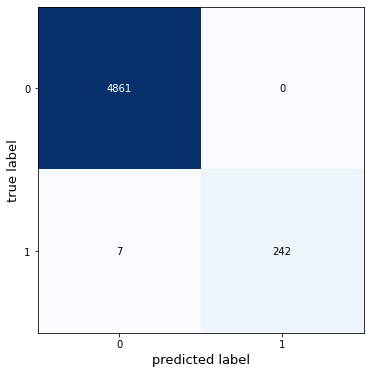

In [70]:
conf_matrix = confusion_matrix(y, ypred)
plot_confusion_matrix(conf_matrix)

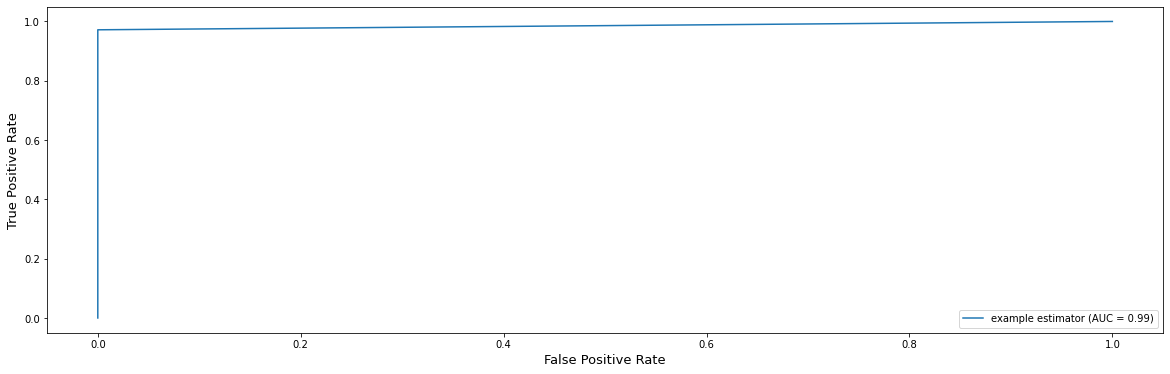

In [71]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y, ypred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()

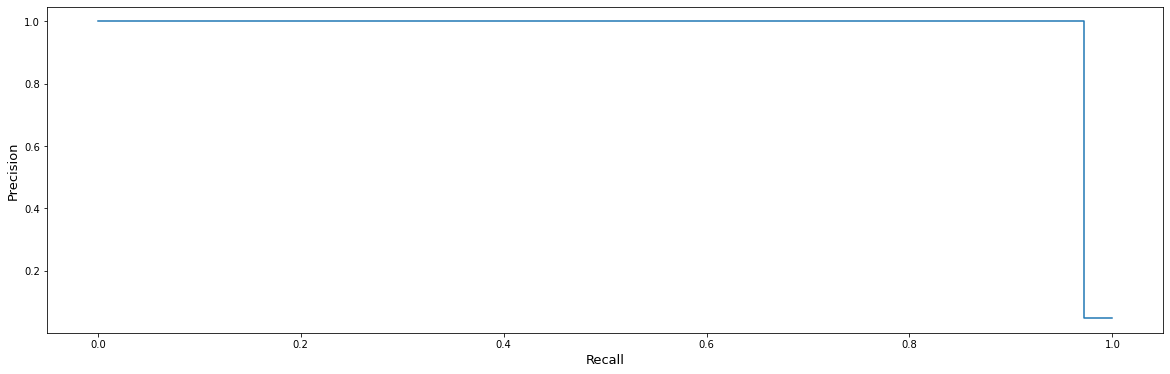

In [76]:
precision, recall, _ = metrics.precision_recall_curve(y, ypred)
disp = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

In [128]:
cat_names = search.best_estimator_.named_steps["preprocessing"].transformers_[0][1].get_feature_names(cat_features).tolist()
all_features = cat_names+num_features
feature_importance = search.best_estimator_.named_steps["GradientBoost"].feature_importances_
df_importance = pd.DataFrame({"feature": all_features, "importance": feature_importance})

In [129]:
fig = px.bar(df_importance.sort_values("importance"), y="feature", x="importance", title="Feature Importance")
fig.update_layout(height=600)
fig.show()